## Topics of hateful titles

Basado fuertemente en [esta notebook](https://github.com/kapadias/mediumposts/blob/master/nlp/published_notebooks/Evaluate%20Topic%20Models.ipynb)

En esta notebook veremos los tópicos de los artículos que generan cierto odio 

**BASADO EN TITULOS** => no funciona bien

In [1]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append("..")
import json
from mongoengine import connect
from hatespeech_models import Tweet, Article

with open("../data/coronavirus-argentina-v2.json") as f:
    all_articles = json.load(f)

In [2]:
articles = [art for art in all_articles if len(art["comments"]) >= 20]

print(len(articles))


6519


In [3]:
sum(len(art["comments"]) for art in articles)

658976

In [4]:
from tqdm.auto import tqdm

for article in tqdm(articles):
    hateful_comments = [c for c in article["comments"] if c["hateful_value"] > 0.5]
    
    article["num_hateful_comments"] = len(hateful_comments)
    article["avg_hateful_comments"] = len(hateful_comments) / len(article["comments"])
    article["avg_hate_value"] = sum(c["hateful_value"] for c in article["comments"]) / len(article["comments"])


<AxesSubplot:>

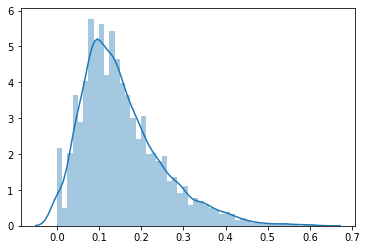

In [6]:
import seaborn as sns


sns.distplot([[art["avg_hateful_comments"] for art in articles]])

In [7]:
hateful_articles = [art for art in articles if art["avg_hateful_comments"] > 0.13]
len(hateful_articles)

3399

In [8]:
# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('spanish')
" - ".join(stop_words)

'de - la - que - el - en - y - a - los - del - se - las - por - un - para - con - no - una - su - al - lo - como - más - pero - sus - le - ya - o - este - sí - porque - esta - entre - cuando - muy - sin - sobre - también - me - hasta - hay - donde - quien - desde - todo - nos - durante - todos - uno - les - ni - contra - otros - ese - eso - ante - ellos - e - esto - mí - antes - algunos - qué - unos - yo - otro - otras - otra - él - tanto - esa - estos - mucho - quienes - nada - muchos - cual - poco - ella - estar - estas - algunas - algo - nosotros - mi - mis - tú - te - ti - tu - tus - ellas - nosotras - vosostros - vosostras - os - mío - mía - míos - mías - tuyo - tuya - tuyos - tuyas - suyo - suya - suyos - suyas - nuestro - nuestra - nuestros - nuestras - vuestro - vuestra - vuestros - vuestras - esos - esas - estoy - estás - está - estamos - estáis - están - esté - estés - estemos - estéis - estén - estaré - estarás - estará - estaremos - estaréis - estarán - estaría - estarías -

## Tokenizar

In [9]:
import spacy
from tqdm.auto import tqdm

nlp = spacy.load("es", disable=["parser", "ner"])

lemmatized_data = []

for art in tqdm(hateful_articles):
    lemmatized_data.append([t.lemma_.lower() for t in nlp(art["title"])])


In [10]:
import string

def is_punct_or_other(tok):
    return (tok in string.punctuation) or ("\n" in tok) or (len(tok) <= 3 and not tok.isalpha())


def filter_words(text):
    non_stop = [tok.strip() for tok in text if tok not in stop_words]
    non_punct = [tok for tok in non_stop if not is_punct_or_other(tok)]
    return non_punct

filtered_data = []

for text in tqdm(lemmatized_data):
    filtered_data.append(filter_words(text))

Sanity check

In [11]:


filter_words([t.string for t in nlp("Hola , esto. es una prueba e33 ?")])

['Hola', 'es', 'una', 'prueba']

In [12]:
import gensim.corpora as corpora

# Create Dictionary
id2word = corpora.Dictionary(filtered_data)

# Create Corpus
texts = filtered_data

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1)]]


In [13]:
import gensim
import pickle

num_topics = range(2, 40, 2)
# Build LDA model

try:
    with open("title_topic_models.pkl", "rb") as f:
        lda_models, coherence_models = pickle.load(f)        
except FileNotFoundError:
    lda_models = {}
    coherence_models = {}

Se me borró el gráfico pero el que mejor daba es 14 

In [14]:

for num in tqdm(num_topics):
    if num in lda_models:
        continue
    model = gensim.models.LdaModel(
        corpus=corpus,
        id2word=id2word,
        num_topics=num, 
        random_state=100,
        chunksize=100,
        passes=10,
        alpha='auto',
        per_word_topics=True)
    lda_models[num] = model
    coherence_models[num] = gensim.models.CoherenceModel(model, texts=texts, corpus=corpus, dictionary=id2word, coherence='c_v')


Salvamos esto

In [15]:
import pickle

with open("title_topic_models.pkl", "wb") as f:
    pickle.dump((lda_models, coherence_models), f)

In [16]:
Y = [k.get_coherence() for k in coherence_models.values()]

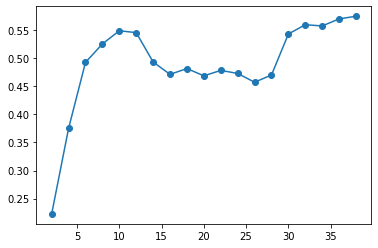

In [17]:
import matplotlib.pyplot as plt


plt.plot([k for k in coherence_models], Y, marker="o")

Agarro 10 que es el más chico donde más o menos deja de crecer

In [18]:
lda_model = lda_models[10]

In [19]:
from pprint import pprint

pprint(lda_model.print_topics())

[(0,
  '0.055*"cristina" + 0.045*"kirchner" + 0.045*"gobierno" + 0.030*"año" + '
  '0.027*"mujer" + 0.023*"pandemia" + 0.019*"casar" + 0.017*"salir" + '
  '0.015*"china" + 0.014*"hijo"'),
 (1,
  '0.059*"tras" + 0.036*"entrar" + 0.028*"vivir" + 0.025*"mesar" + '
  '0.024*"cruzar" + 0.019*"dejar" + 0.018*"tres" + 0.018*"cerrar" + '
  '0.016*"nunca" + 0.016*"cuestionar"'),
 (2,
  '0.101*"vicentin" + 0.033*"personar" + 0.025*"alimento" + 0.019*"armar" + '
  '0.017*"detener" + 0.015*"aire" + 0.014*"impedir" + 0.014*"quilmes" + '
  '0.014*"sagasti" + 0.012*"disparar"'),
 (3,
  '0.025*"pagar" + 0.024*"vida" + 0.022*"docente" + 0.020*"tratar" + '
  '0.016*"virtual" + 0.016*"responder" + 0.016*"clase" + 0.015*"ernestina" + '
  '0.015*"historia" + 0.015*"anunciar"'),
 (4,
  '0.085*"ser" + 0.071*"parir" + 0.047*"fernández" + 0.040*"alberto" + '
  '0.034*"cuarentena" + 0.033*"coronavirus" + 0.028*"sobrar" + '
  '0.028*"argentina" + 0.024*"pedir" + 0.022*"ir"'),
 (5,
  '0.060*"país" + 0.031*"solo" 

In [20]:
# Print the Keyword in the 10 topics

doc_lda = lda_model[corpus]

In [21]:
# Visualize the topics
import pyLDAvis
import pyLDAvis.gensim

pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word, mds='mmds')
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4     -0.030840  0.427276       1        1  27.278819
0     -0.011147 -0.421233       2        1  15.076868
9     -0.378699 -0.152423       3        1  12.448732
8     -0.299280  0.234332       4        1  11.416537
7      0.278170 -0.237736       5        1   9.184979
1      0.358595  0.029981       6        1   7.107131
6      0.216598  0.251672       7        1   6.856155
3     -0.067432 -0.175675       8        1   4.923386
5     -0.147057  0.028808       9        1   3.431932
2      0.081091  0.014998      10        1   2.275460, topic_info=           Term        Freq       Total Category  logprob  loglift
96          ser  735.000000  735.000000  Default  30.0000  30.0000
130       parir  614.000000  614.000000  Default  29.0000  29.0000
125   fernández  408.000000  408.000000  Default  28.0000  28.0000
515    cristina  262.000000  262.000000  Default  27.0000  27.0000
10        tener  210.000000  210.000000  Default  26.0000  26.0000
...         ...         ...         ...      ...      ...      ...
4644      buque    4.237618    5.081557  Topic10  -5.1397   3.6014
2088     estero    3.766965    4.608372  Topic10  -5.2574   3.5814
1171   farmacia    3.459971    4.302030  Topic10  -5.3424   3.5652
4836     franco    3.511123    4.382038  Topic10  -5.3277   3.5614
342      masiva    3.872266    4.857143  Topic10  -5.2298   3.5564

[331 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
371       1  0.980783     abrir
50        4  0.956074  advertir
208       3  0.981883     ahora
1387     10  0.933034      aire
121       1  0.999064   alberto
...     ...       ...       ...
185       1  0.993633    violar
839       8  0.979964   virtual
511       6  0.994644     vivir
97        1  0.997325    volver
854       2  0.986419   wiñazki

[301 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 1, 10, 9, 8, 2, 7, 4, 6, 3])

1. Tema "general" (verbos, y otras cosas)
2. Tema "internacional" (China, Trump, avión, extranjero, George Floyd, otros
3. AMBA/CABA: Kicillof, Larreta, Berni: política CABA, AMBA y demás
4. Mujeres y feminismo
5. JxC vs FDT: Macri, Cristina, expropiación, Senado, etc
6. Judiciales/Policiales
7. Conflictos sindicales y económicos: Moyano, pago, grabois, ife, k, camioneros,e tc
8. Notas económicas: dólar, pobreza, silobolsas, default, impuestos, guzmán
9. Salud
10. Conflictos "campo": Vicentín y silobolsas
11. China y su comida?
12. Ruido


In [22]:
temas = [
    "general",
    "internacional",
    "amba/caba",
    "mujeres",
    "cambiemos vs fdt",
    "judiciales y policiales",
    "sindicales",
    "económicas",
    "salud",
    "Campo conflictos",
    "China comida?",
    "Ruido",
]

len(temas)

12

In [23]:
len(corpus), len(hateful_articles)

(3399, 3399)

In [47]:
num = 3

def display_topics(num):
    print(hateful_articles[num]["title"])
    
    topics = lda_model.get_document_topics(corpus[num])
    
    
    print(" + ".join(f"{temas[idx]} * {porc:.2f}" for idx, porc in topics))


for num in range(len(hateful_articles)):
    print("=" * 80 + '\n\n')
    
    display_topics(num)



Los contagios confirmados por dengue superan los 41 mil y 2020 ya tiene el mayor número de casos de la historia
internacional * 0.21 + amba/caba * 0.36 + cambiemos vs fdt * 0.02 + judiciales y policiales * 0.07 + salud * 0.03 + Campo conflictos * 0.11 + China comida? * 0.20


Cambios en el directorio de YPF. Asumieron Héctor Recalde y Celso Jaque
internacional * 0.19 + amba/caba * 0.06 + mujeres * 0.04 + cambiemos vs fdt * 0.02 + sindicales * 0.18 + económicas * 0.34 + salud * 0.07 + Campo conflictos * 0.11


Coronavirus en Argentina: en countries de zona Norte pidieron que jardineros y pileteros trabajaran igual pese a la cuarentena
internacional * 0.16 + amba/caba * 0.17 + mujeres * 0.03 + cambiemos vs fdt * 0.02 + judiciales y policiales * 0.11 + sindicales * 0.15 + Campo conflictos * 0.33 + China comida? * 0.02


Brasil se encamina a la tormenta perfecta: coronavirus, influenza, dengue y sarampión
internacional * 0.26 + amba/caba * 0.30 + económicas * 0.04 + salud * 0.08 + Campo 

In [ ]:
lda_model.get_document_topics()